### Introduction

In this notebook, our group performed a network and a text analysis. 
1. Network analysis
We visualized the products and the orders as a network. The nodes of the network are the products and if two products are included in the same order, there are linked with an edge. To build it we utilized the olist_order_items_dataset which included 32951 different products and 98666 different orders. We managed to generate the network for all these products and orders but it was very time-consuming and quite complex. Instead, We chose to visualize only the network for the 1000 most popular products. We kept all the information for the whole dataset and plotted the degree distribution to find out how many products are included in the average order.
2. Text analysis
To perform the text analysis, we accessed the translated olist_reviews_dataset that a fellow student shared. The dataset included the comments and the titles translated. Using those two columns we generated two wordclouds, one for each. We also performed an LDA topic analysis only for the comments of the reviews. Finally, we performed sentiment analysis for the comments of the reviews.

In [252]:
# Install necessary libraries

!pip install nltk
!pip install wordcloud

In [306]:
# Import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt

# For network
import networkx as nx
from itertools import combinations,chain

# For text analysis
import numpy as np
from stopwords import get_stopwords
import string
from nltk.stem import WordNetLemmatizer
from PIL import Image
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# For plotting layout
import seaborn as sns
import cycler

The plotting style can be found here [cyberpunk-style-with-matplotlib](https://towardsdatascience.com/cyberpunk-style-with-matplotlib-f47404c9d4c5).

In [4]:
# Setting up plot layouts:

plt.style.use("seaborn-darkgrid")

for p1,p2,p3 in zip(['figure.facecolor', 'axes.facecolor', 'savefig.facecolor', 'savefig.facecolor'],['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color'],['font.size', 'xtick.labelsize', 'ytick.labelsize', 'ytick.labelsize']):
    plt.rcParams[p1], plt.rcParams[p2], plt.rcParams[p3] = '#212946', '0.95', '16'

plt.rcParams['figure.figsize']=(15, 15)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['legend.frameon'] = 'True'
plt.rcParams['legend.facecolor'] = '004466'
plt.rcParams['legend.edgecolor'] = '004466'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=[u'#00ff00',u'#ffff00',u'#00ffff',u'#ff00ff',u'#ffaa00',u'#ff0000',u'#0000ff',u'#00aa00',u'#aaaa00',u'#038273',u'#7d0ec2',u'#822d13',u'#720303',u'#000022'])


# 1. Network

In [36]:
data=pd.read_csv(r"C:\Users\Maria Papaioannou\Desktop\Advanced_\olist_order_items_dataset.csv")
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


To have an overview of the items and the orders they were included in, we decided to visualize them as a network. 
The graph aims to identify which items are connected the most. The nodes of the network will represent the products and the edges between them whether or not those two products were included in the same order. The graph will be simple, meaning that it will be undirected and with no self-loops.

In [37]:
print("There are {} different products included in {} different orders.".format(len(data['product_id'].unique()),len(data['order_id'].unique())))

There are 32951 different products included in 98666 different orders.


Since the volume of the data is somewhat large, we will generate a network of the 1000 most popular products.

In [157]:
n=1000
products_dict=dict(data['product_id'].value_counts()[:n])
popular_products=list(products_dict.keys())

data_nx=data[data['product_id'].isin(popular_products)]

In [158]:
#n1=200
#data['product_id'].value_counts()[:n1]
data_nx.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88
12,0006ec9db01a64e59a68b2c340bf65a7,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,2018-07-26 17:24:20,74.00,23.32
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
17,000aed2e25dbad2f9ddb70584c5a2ded,1,4fa33915031a8cde03dd0d3e8fb27f01,fe2032dab1a61af8794248c8196565c9,2018-05-16 20:57:03,144.00,8.77


In [159]:
# Create an empty undirected graph
G = nx.Graph()

# Add the nodes.
G.add_nodes_from(data_nx['product_id'])
#len(list(G.nodes))


In [160]:
uniq_order_ids = data_nx['order_id'].unique()
# len(uniq_order_ids)

In [161]:
output_list = []

for order_id in uniq_order_ids:
    product_ids = data_nx.loc[data_nx['order_id'] == order_id, 'product_id'].tolist()
    output_list.extend(list(combinations(product_ids, 2)))

In [162]:
# # Add the edges.

G.add_edges_from(output_list)

In [236]:
degrees=dict(G.degree()) # Calculates the degree for each node in a dictionary

In [163]:
# Information on the graph.

print("The network representing the 2000 most popular products includes {} nodes and {} links among them.".format(len(G.nodes),len(G.edges)))

The network representing the 2000 most popular products includes 1000 nodes and 952 links among them.


In [229]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 952
Average degree:   1.9040


### Visualization

For the visualization of the network, we wanted to give each node size proportional to its degree. Because the average degree of the nodes was 1.9 and was not visible in the network, to generate it we multiplied each degree by 100.

In [164]:
# kamada kawai layout
pos= nx.kamada_kawai_layout(G) 

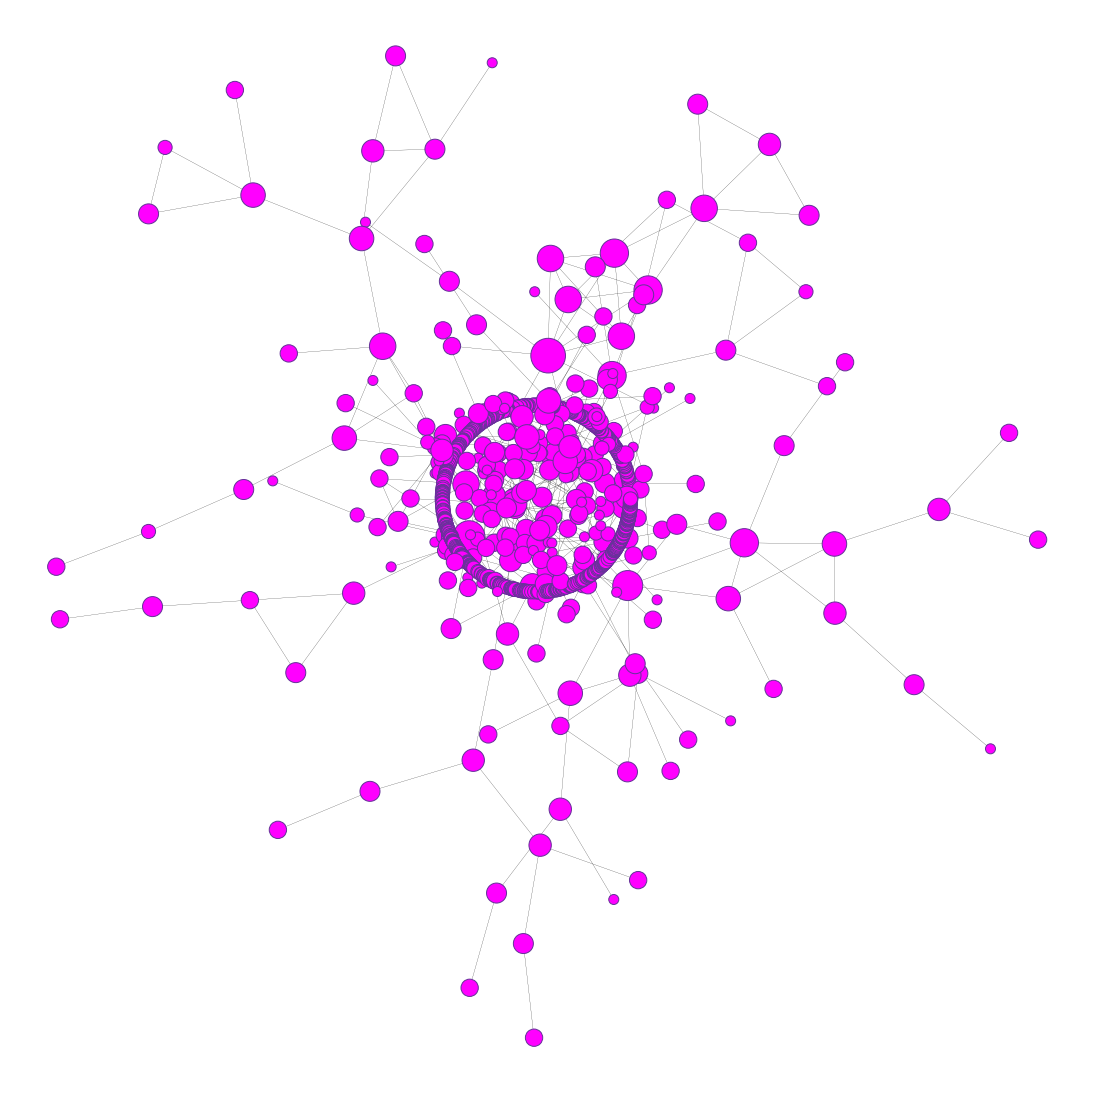

In [235]:
# Node size according to each node's degree

plt.rcParams["figure.figsize"] = (15,15)
nx.draw(G, pos, node_size=[deg* 100 for deg in degrees.values()], node_color='fuchsia', edgecolors='rebeccapurple', width=0.2)
#nx.draw(G, pos, node_size=100, node_color='fuchsia', edgecolors='#fcff52', width=0.2)

plt.show()

### Degree distribution

The degree of a node is the number of links it has to other nodes.

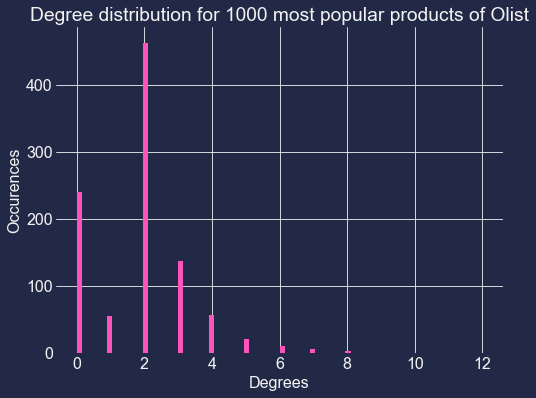

In [325]:
degrees = [G.degree(n) for n in G.nodes()]

plt.rcParams["figure.figsize"] = (8,6)

plt.hist(degrees,bins=80,color='#FE53BB')
plt.title('Degree distribution for 1000 most popular products of Olist')
plt.ylabel('Occurences')
plt.xlabel('Degrees')
plt.show()


In the degree distribution, it is shown that almost half of the popular products have a degree of 2. Translated in the data, that means that most of the popular products are included in the order by 3.

# 2. Text analysis

In [244]:
df= pd.read_excel(r"C:\Users\Maria Papaioannou\Desktop\Advanced_\olist_reviews_with_translation.xlsx")

In [245]:
df.head()

,Unnamed: 0,review_id,order_id,review_score,review_comment_title,review_comment_title_translated,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_message_translated
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,NaN
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,NaN
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,NaN
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,I received it well before the stipulated deadl...
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Congratulations lannister stores loved shoppin...


In [246]:
# Search for NaN values

hasnan_df = 100 * df.isna().sum() / df.shape[0]

# The columns with nans

hasnan_df[hasnan_df > 0]

review_comment_title                 88.285
review_comment_title_translated      88.287
review_comment_message               58.247
review_comment_message_translated    58.275
dtype: float64

In [247]:
# The columns with no nans

df[hasnan_df[hasnan_df == 0].index.values]

,Unnamed: 0,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...
99995,99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,2018-03-22 00:00:00,2018-03-23 09:10:43
99997,99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,2017-12-15 00:00:00,2017-12-16 01:29:43


### 2.1 Normalization of the text and wordcloud vizualization

Before creating the word clouds for the reviews comments and the titles of the reviews, we preprocessed the text. 
Firstly, we removed punctuation from the text of the reviews, we turned every word to lowercase, and removed the stopwords. The final step of this process was the lemmatizing of every word. A lemmatizer converts a word to its original meaningful form.

In [248]:
lemmatizer = WordNetLemmatizer()

stop_words=get_stopwords('en')

def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split()  if w not in stop_words])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [249]:
extra_stopwords=['nan','product']
for i in extra_stopwords:
    stop_words.append(i)

In [250]:
# df['clean_review_comment'] = df['review_comment_message_translated'].apply(text_processing)
text_processing_vec = np.vectorize(text_processing)
df['clean_review_comment'] = df['review_comment_message_translated'].astype(str).apply(text_processing_vec)
df['clean_review_title'] = df['review_comment_title_translated'].astype(str).apply(text_processing_vec)

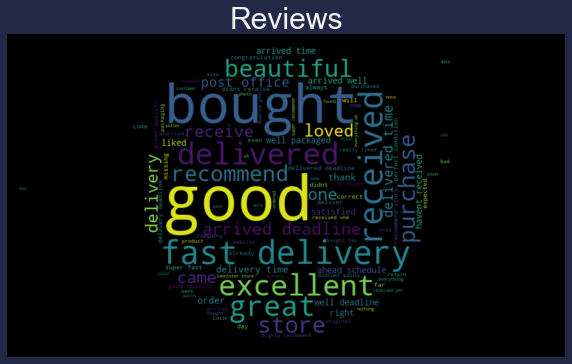

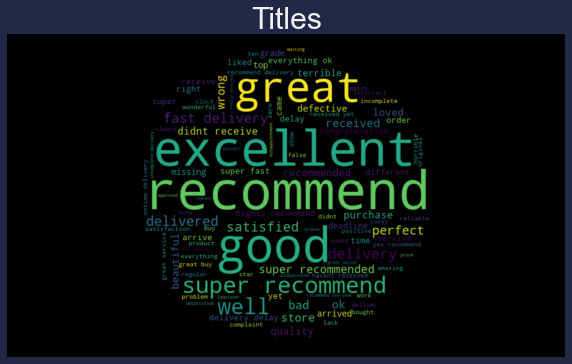

In [271]:
mask_o=np.array(Image.open(r"C:\Users\Maria Papaioannou\Desktop\circle.jpg"))

def show_wordcloud(df, title):
    text = ' '.join(df['clean_review_comment'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,mask=mask_o,max_font_size=100, max_words=100, background_color="black").generate(text)
    
    plt.figure(figsize=(10,10), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

show_wordcloud(df, "Reviews")


def show_wordcloud(df, title):
    text = ' '.join(df['clean_review_title'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,mask=mask_o,max_font_size=100, max_words=100, background_color="black").generate(text)
    
    plt.figure(figsize=(10,10), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

show_wordcloud(df, "Titles")


## 2.2 Topic modeling with LDA

LDA (Latent Dirichlet Allocation) is an unsupervised machine learning technique that is used to classify text to a particular topic. We are planning to use it to get insights on user satisfaction for Olist and possible complaints.

First step for LDA topic modeling is to turn the text into a format that can be used in machine learning. This process is called "vectorization".

In [351]:
# Vectorize reviews comments

vectorizer_comments = CountVectorizer(ngram_range=(2, 2))
bow_counts_comments = vectorizer_comments.fit_transform(df['clean_review_comment'].values)
# print(bow_counts_comments[0])
# print(vectorizer_comments.get_feature_names())
print(len(vectorizer_comments.vocabulary_))

98972


Second step for the topic modeling is building the model. It will classify the text of the comments in 3 different topics.

In [335]:
from sklearn.decomposition import LatentDirichletAllocation

# empty model
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [339]:
comments_lda = lda.fit_transform(bow_counts_comments)

In [344]:
# Function that prints n top words
# Ref: Course's Notebook text Analysis - Part 1 - Spam Classification-solutions
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

In [352]:
print("\nTopics in LDA model:")
counts_feature_names = vectorizer_comments.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in LDA model:
--------------------------------------------------------------------------------
Topic 0
0.010	post office
0.009	delivery time
0.007	havent received
0.007	delivered deadline
0.007	perfect condition
0.006	good quality
0.005	recommend store
0.004	received yet
0.003	long time
0.003	met expectation
--------------------------------------------------------------------------------
Topic 1
0.018	fast delivery
0.009	well packaged
0.007	super fast
0.005	didnt receive
0.004	lannister store
0.003	super recommend
0.003	delivered well
0.003	didnt like
0.003	delivery fast
0.003	scheduled date
--------------------------------------------------------------------------------
Topic 2
0.012	arrived deadline
0.010	delivered time
0.009	well deadline
0.008	arrived well
0.007	arrived time
0.006	highly recommend
0.005	really liked
0.004	excellent quality
0.003	ahead time
0.003	deadline recommend
--------------------------------------------------------------------------------
Topic 3
0.008

## 2.3 Sentiment analysis

After generating the wordclouds for each review titles and review comments our group performed a sentiment analysis. The sentiment analysis was based on the file happiness.

In [87]:
happinessDf = pd.read_csv(r"C:\Users\Maria Papaioannou\Desktop\happinessDataSet.csv",',')
happinessDf.head()
#happinessDf.happiness_average.sort_values()
#happinessDf.happiness_rank.sort_values()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [88]:
review_sent = {}  # Dict for sentimal(value) for each review(key)

In [89]:
# Turn the columns word and happiness_average to list

wordList = happinessDf['word'].tolist()
happAvgList = happinessDf['happiness_average'].tolist()

In [90]:
# Function that will take as inputs the review and the tokens of the review 

def sentiment_calculator(review, tokens):
    happList = []
    for t in tokens:
        if t in wordList: # If token is in data set of words
            indexWord = wordList.index(t) # find index of word 
            happList.append(happAvgList[indexWord]) # find happines score of token
    review_sent[review] = np.average(happList) 

In [ ]:
# user satisfaction, in case there are complaints 

### Conclusion

As shown both in wordclouds and in the topic modelling, most reviews are positive.